In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
orders = pd.read_csv('Order.csv')

cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

In [5]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [7]:
order_details.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [15]:
round(ols(formula='Quantity ~ Discount', data=order_details).fit().pvalues,5)

Intercept    0.0
Discount     0.0
dtype: float64

In [16]:
round(ols(formula='Quantity ~ Discount*UnitPrice', data=order_details).fit().pvalues,5)

Intercept             0.00000
Discount              0.00062
UnitPrice             0.72206
Discount:UnitPrice    0.18165
dtype: float64

In [17]:
orders.ShipCountry.value_counts()

USA            122
Germany        122
Brazil          83
France          77
UK              56
Venezuela       46
Austria         40
Sweden          37
Canada          30
Italy           28
Mexico          28
Spain           23
Finland         22
Ireland         19
Belgium         19
Denmark         18
Switzerland     18
Argentina       16
Portugal        13
Poland           7
Norway           6
Name: ShipCountry, dtype: int64

In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [19]:
order_countries = orders[['Id','ShipCountry']]

In [20]:
order_disc_quan = order_details[['OrderId','Discount','Quantity']]

In [34]:
df = pd.merge(order_countries, 
                  order_disc_quan,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')

In [35]:
df.head()

,Id,ShipCountry,OrderId,Discount,Quantity
0,10248,France,10248,0.0,12
1,10248,France,10248,0.0,10
2,10248,France,10248,0.0,5
3,10249,Germany,10249,0.0,9
4,10249,Germany,10249,0.0,40


In [36]:
df = df.join(pd.get_dummies(df.ShipCountry))
df.drop('ShipCountry', axis=1,inplace=True)

In [37]:
df.head()

,Id,OrderId,Discount,Quantity,Argentina,Austria,Belgium,Brazil,Canada,Denmark,...,Mexico,Norway,Poland,Portugal,Spain,Sweden,Switzerland,UK,USA,Venezuela
0,10248,10248,0.0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10248,10248,0.0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10248,10248,0.0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10249,10249,0.0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10249,10249,0.0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
columns = "+Discount*".join(df.drop(['Quantity', 'OrderId', 'Id', 'Discount'], axis=1).columns)
f = 'Quantity~' + columns
round(ols(formula=f, data=df).fit().pvalues,5)

Intercept               0.00000
Argentina               0.00148
Discount                0.00793
Austria                 0.00000
Discount:Austria        0.80675
Belgium                 0.06913
Discount:Belgium        0.95399
Brazil                  0.28254
Discount:Brazil         0.15655
Canada                  0.08433
Discount:Canada         0.24064
Denmark                 0.05474
Discount:Denmark        0.50017
Finland                 0.17757
Discount:Finland        0.99639
France                  0.22033
Discount:France         0.42195
Germany                 0.00000
Discount:Germany        0.54808
Ireland                 0.02883
Discount:Ireland        0.59266
Italy                   0.19352
Discount:Italy          0.65784
Mexico                  0.00988
Discount:Mexico         0.73811
Norway                  0.02897
Discount:Norway         0.49321
Poland                  0.12220
Discount:Poland         0.78604
Portugal                0.74382
Discount:Portugal       0.61090
Spain   

In [55]:
order_details.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

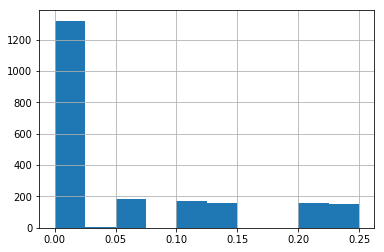

In [45]:
order_details.Discount.hist()

In [57]:
disc_05 = order_details[['Quantity','Discount']][(order_details.Discount<0.05) & (order_details.Discount>0)]
disc_15 = order_details[['Quantity','Discount']][(order_details.Discount<0.15) & (order_details.Discount > 0.05)]
disc_25 = order_details[['Quantity','Discount']][order_details.Discount>0.15]
print("Less than 5% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_05).fit().pvalues[1],5)))
print("Between 5% and 15% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_15).fit().pvalues[1],5)))
print("Between 15% and 25% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_25).fit().pvalues[1],5)))

Less than 5% : 0.34871
Between 5% and 15% : 0.27565
Between 15% and 25% : 0.58015


In [135]:
d = 0
for i in sorted(order_details.Discount.unique()):
    d = order_details[['Quantity', 'Discount']][order_details.Discount==i].copy()
    print(str(i)+ " : " + str(ols(formula='Quantity ~ Discount', data=d).fit().pvalues[1]))

C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: invalid value 

0.0 : nan
0.01 : nan
0.02 : 0.2951672353008664
0.03 : 0.037749551350623724
0.04 : nan
0.05 : 4.5477484785587396e-40
0.06 : nan
0.1 : 6.00589433967154e-35
0.15 : 2.4926940742089617e-37
0.2 : 7.745444908882207e-41
0.25 : 3.864037164219324e-38


In [153]:
no_disc = order_details[order_details['Discount'] == 0].copy()
disc = order_details[order_details['Discount'] > 0].copy()
print(no_disc.Quantity.mean())
print(disc.Quantity.mean())

21.715261958997722
27.10978520286396


In [162]:
from scipy import stats
print(stats.ttest_ind(no_disc.Quantity, disc.Quantity))
print(stats.ttest_ind(no_disc.Quantity, disc.Quantity, equal_var = False))

Ttest_indResult(statistic=-6.4785631962949015, pvalue=1.1440924523215966e-10)
Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)


In [195]:
for i in values:
    print (str(i) + " : " + str(order_details['Quantity'][order_details['Discount'] == i].value_counts().sum()))

0.01 : 1
0.02 : 2
0.03 : 3
0.04 : 1
0.05 : 185
0.06 : 1
0.1 : 173
0.15 : 157
0.2 : 161
0.25 : 154


In [200]:
disc_5 = order_details['Quantity'][order_details['Discount'] <= 0.05]
disc_10 = order_details['Quantity'][(order_details['Discount'] > 0.05) & (order_details['Discount'] <= 0.1)]
disc_15 = order_details['Quantity'][(order_details['Discount'] > 0.1) & (order_details['Discount'] <= 0.15)]
disc_20 = order_details['Quantity'][(order_details['Discount'] > 0.15) & (order_details['Discount'] <= 0.2)]
disc_25 = order_details['Quantity'][order_details['Discount'] > 0.2]
buckets = [(0.05, disc_5), (0.1, disc_10), (0.15, disc_15), (0.2, disc_20), (0.25,disc_25)]
c = 0 
while c < len(buckets) - 1:
    x = buckets[c][1]
    y = buckets[c+1][1]
    p = stats.ttest_ind(x,y)[1]
    print(str(buckets[c][0]) + " v.s. " + str(buckets[c+1][0]) + " : " + str(p)) 
    c += 1

0.05 v.s. 0.1 : 0.06894702109397166
0.1 v.s. 0.15 : 0.15837034442401487
0.15 v.s. 0.2 : 0.5433964640207652
0.2 v.s. 0.25 : 0.5801473824667989


In [142]:
d = 0
for i in sorted(order_details.Discount.unique()):
    d = order_details[['Quantity', 'Discount', 'UnitPrice']][order_details.Discount==i].copy()
    print(str(i)+ " : " + str(ols(formula='Quantity ~ Discount*UnitPrice', data=d).fit().pvalues))

0.0 : Intercept             7.411799e-180
Discount                        NaN
UnitPrice              9.064651e-01
Discount:UnitPrice              NaN
dtype: float64
0.01 : Intercept            NaN
Discount             NaN
UnitPrice            NaN
Discount:UnitPrice   NaN
dtype: float64
0.02 : Intercept            NaN
Discount             NaN
UnitPrice            NaN
Discount:UnitPrice   NaN
dtype: float64
0.03 : Intercept             0.583441
Discount              0.583441
UnitPrice             0.903053
Discount:UnitPrice    0.903053
dtype: float64
0.04 : Intercept            NaN
Discount             NaN
UnitPrice            NaN
Discount:UnitPrice   NaN
dtype: float64
0.05 : Intercept             1.648741e-30
Discount              1.648741e-30
UnitPrice             7.363890e-01
Discount:UnitPrice    7.363890e-01
dtype: float64
0.06 : Intercept            NaN
Discount             NaN
UnitPrice            NaN
Discount:UnitPrice   NaN
dtype: float64
0.1 : Intercept             1.751155e-2

C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: invalid value 

In [63]:
disc_05 = order_details[['Quantity','Discount', 'UnitPrice']][(order_details.Discount<0.05) & (order_details.Discount>0)]
disc_15 = order_details[['Quantity','Discount', 'UnitPrice']][(order_details.Discount<0.15) & (order_details.Discount > 0.05)]
disc_25 = order_details[['Quantity','Discount', 'UnitPrice']][order_details.Discount>0.15]
print("Less than 5% : " + str(round(ols(formula='Quantity ~ Discount*UnitPrice', data=disc_05).fit().pvalues[1:3],5)))
print("Between 5% and 15% : " + str(round(ols(formula='Quantity ~ Discount*UnitPrice', data=disc_15).fit().pvalues[1:3],5)))
print("Between 15% and 25% : " + str(round(ols(formula='Quantity ~ Discount*UnitPrice', data=disc_25).fit().pvalues[1:3],5)))

Less than 5% : Discount     0.43646
UnitPrice    0.26537
dtype: float64
Between 5% and 15% : Discount     0.00000
UnitPrice    0.27294
dtype: float64
Between 15% and 25% : Discount     0.67142
UnitPrice    0.66832
dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [69]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_ord_details.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00


In [74]:
prod_ord_details_cat = pd.merge(prod_ord_details, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
prod_ord_details_cat.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


In [100]:
df_cat_disc = prod_ord_details_cat.filter(['Quantity', 'Discount','CategoryName'], axis=1)
df_cat_disc = prod_ord_details_cat.join(pd.get_dummies(df_cat_disc.CategoryName))
df_cat_disc.CategoryName.unique()

array(['Beverages', 'Condiments', 'Produce', 'Meat/Poultry', 'Seafood',
       'Dairy Products', 'Confections', 'Grains/Cereals'], dtype=object)

In [115]:
a = prod_ord_details_cat[['Quantity', 'Discount', 'CategoryName']].copy()
a = a.join(pd.get_dummies(a.CategoryName))
a.drop('CategoryName', axis=1, inplace=True)
a.columns = [c.replace(' ', '_') for c in a.columns]
a.columns = [c.replace('/', '_') for c in a.columns]

In [116]:
a.head()

,Quantity,Discount,Beverages,Condiments,Confections,Dairy_Products,Grains_Cereals,Meat_Poultry,Produce,Seafood
0,45,0.20,1,0,0,0,0,0,0,0
1,18,0.00,1,0,0,0,0,0,0,0
2,20,0.00,1,0,0,0,0,0,0,0
3,15,0.15,1,0,0,0,0,0,0,0
4,12,0.00,1,0,0,0,0,0,0,0


In [117]:
columns = "+Discount*".join(a.drop(['Quantity', 'Discount'], axis=1).columns)
f = 'Quantity~' + columns
round(ols(formula=f, data=a).fit().pvalues,5)

Intercept                  0.00000
Beverages                  0.03006
Discount                   0.01705
Condiments                 0.06200
Discount:Condiments        0.38987
Confections                0.00610
Discount:Confections       0.47316
Dairy_Products             0.00962
Discount:Dairy_Products    0.21475
Grains_Cereals             0.03119
Discount:Grains_Cereals    0.50771
Meat_Poultry               0.42278
Discount:Meat_Poultry      0.16951
Produce                    0.29870
Discount:Produce           0.59926
Seafood                    0.09724
Discount:Seafood           0.89421
dtype: float64

In [123]:
cust_demos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
Id              0 non-null object
CustomerDesc    0 non-null object
dtypes: object(2)
memory usage: 0.0+ bytes


C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


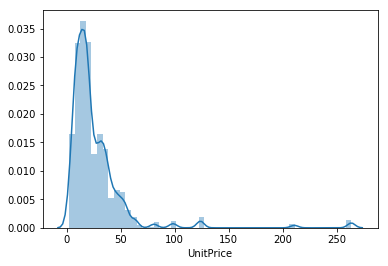

In [212]:
sns.distplot(order_details.UnitPrice)

C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


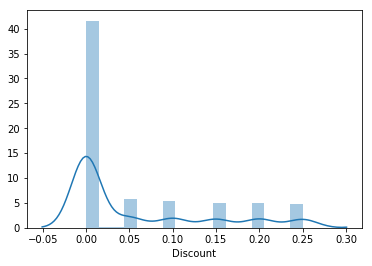

In [213]:
sns.distplot(order_details.Discount)